The problem number 6.9.32

Фунции нахождения частных разностей divided_diff и интерполяции в форме Ньютона newton_poly

Ошибка опредления населения США при экстраполяции в 2010 519160970


C:\Users\tengi\AppData\Local\Temp\ipykernel_32396\2257355365.py:34: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_new[100], y_new[100], 'ro', markersize=8, label='Экстраполированная точка(население в 2010 году в США)', color = 'black')


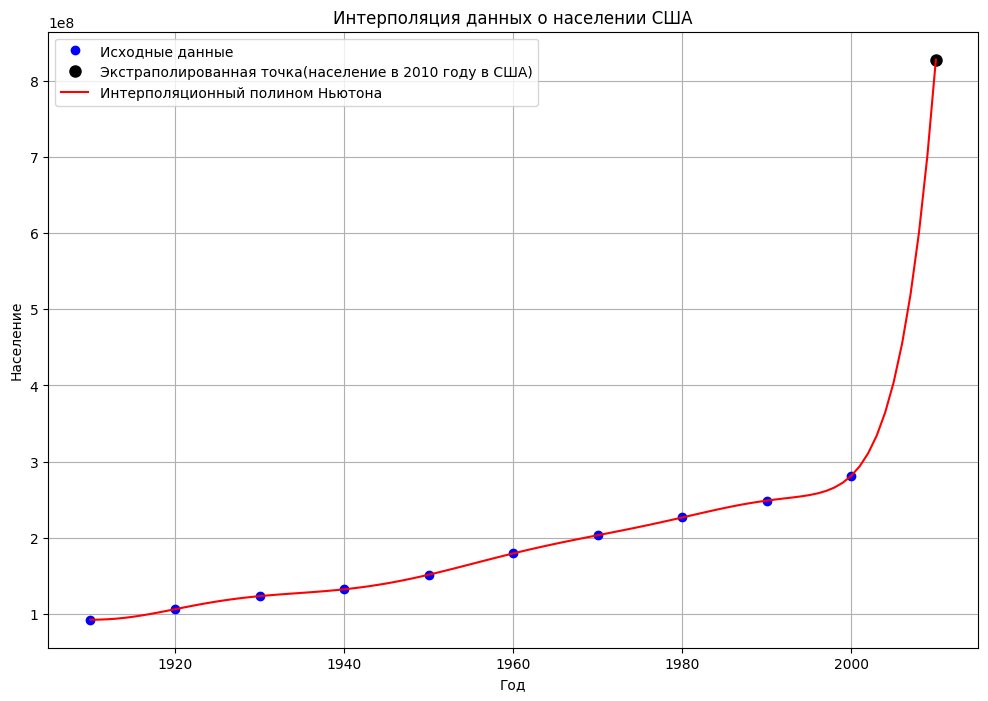

10
10


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000])
y = np.array([92228496, 106021537, 123202624, 132164569, 151325798, 179323175, 
              203211926, 226545805, 248709873, 281421906])

def divided_diff(x, y):
    n = len(x)
    coef = np.zeros([n, n])
    coef[:, 0] = y 
    
    for j in range(1, n):
        for i in range(n - j):
            coef[i][j] = (coef[i+1][j-1] - coef[i][j-1]) / (x[i+j] - x[i])
    
    return coef[0, :]

def newton_poly(coef, x_data, x):
    n = len(x_data) - 1
    p = coef[n]
    
    for k in range(1, n+1):
        p = coef[n-k] + (x - x_data[n-k]) * p
    
    return p
a_s = divided_diff(x, y)
x_new = np.arange(1910, 2011, 1)
y_new = newton_poly(a_s, x, x_new)
print('Ошибка опредления населения США при экстраполяции в 2010', int(y_new[100] - 308745538) - 1)

plt.figure(figsize=(12, 8))
plt.plot(x, y, 'bo', label='Исходные данные')
plt.plot(x_new[100], y_new[100], 'ro', markersize=8, label='Экстраполированная точка(население в 2010 году в США)', color = 'black')
plt.plot(x_new, y_new, 'r-', label='Интерполяционный полином Ньютона')
plt.xlabel('Год')
plt.ylabel('Население')
plt.title('Интерполяция данных о населении США')
plt.legend()
plt.grid(True)
plt.show()

Теперь вместо интерполяции одним многочленом, который сильно подстраивается под данные и возникает 'переобучение', будет строить интерполяцию сплайнами, то есть на каждом отрезке между ближайшими узлами будет строить полиномиальную интерполяцию малых степеней.

Интерполяция линейными сплайнами

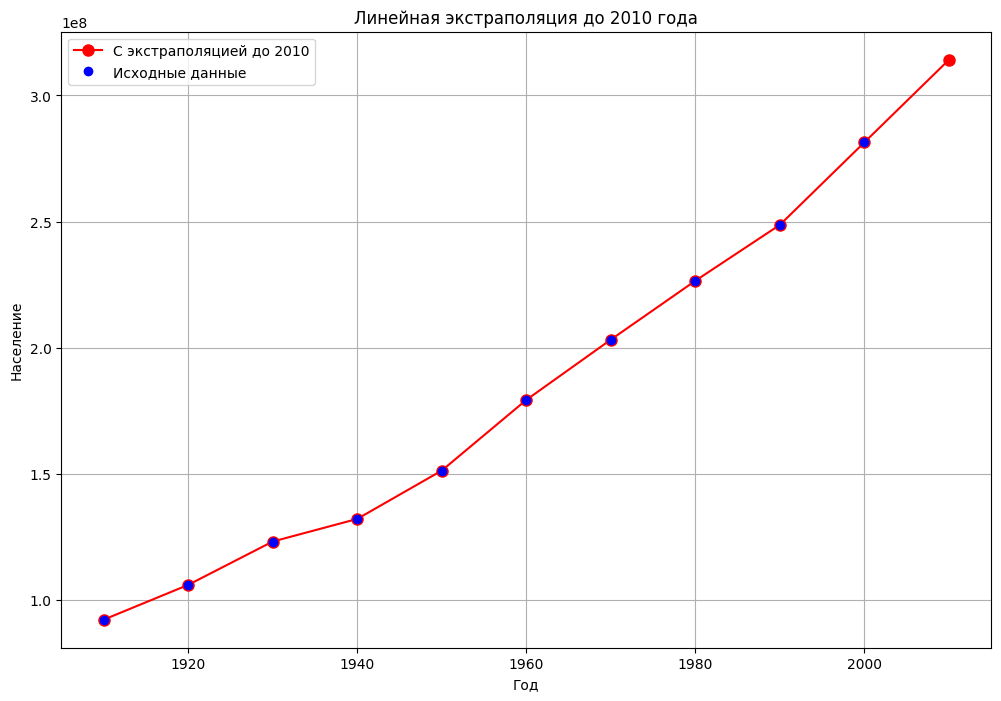

Прогноз населения на 2010 год: 314133939 человек


In [52]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000])
y = np.array([92228496, 106021537, 123202624, 132164569, 151325798, 
              179323175, 203211926, 226545805, 248709873, 281421906])

x_extra = 2010
coef = (y[-1] - y[-2]) / (x[-1] - x[-2])
y_extra = y[-1] + coef * (x_extra - x[-1])

x_n = np.append(x, x_extra)
y_n = np.append(y, y_extra)

plt.figure(figsize=(12, 8))
plt.plot(x_n, y_n, 'ro-', markersize=8, label='С экстраполяцией до 2010')
plt.plot(x, y, 'bo', markersize=6, label='Исходные данные')
plt.xlabel('Год')
plt.ylabel('Население')
plt.title('Линейная экстраполяция до 2010 года')
plt.legend()
plt.grid(True)
plt.show()

print(f"Прогноз населения на 2010 год: {y_extra:.0f} человек")

Интерполяция кубическими сплайнами

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x = np.array([1910, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000])
y = np.array([92228496, 106021537, 123202624, 132164569, 151325798, 
              179323175, 203211926, 226545805, 248709873, 281421906])
def divided_diff(x, y):
    n = len(x)
    coef = np.zeros([n, n])
    coef[:, 0] = y 
    
    for j in range(1, n):
        for i in range(n - j):
            coef[i][j] = (coef[i+1][j-1] - coef[i][j-1]) / (x[i+j] - x[i])
    return coef[0, :]
#u_0 не нужен в системе, поэтому
#массив hi
h = np.array()
for i in range(len(x) - 1):
    h[i] = x[i + 1] - x[i]
#массив разделенных разностей
u = divided_diff(x, y)
#алгоритм прогонки
def solve_spline_system(h, u):
    N = len(h)
    n_unknown = N - 1 #кол-во неизвестных
    xi = np.zeros(n_unknown) #прогоночные коэффициенты кси
    etta = np.zeros(n_unknown) #прогоночные коэффициенты этта
    c = np.zeros(N + 1) #итоговый массив коэффициентов

    #прямой ход
    #i = 1
    xi[0] = - (h[1] / (h[0] + h[1])) / 2
    etta[0] = 3 * u[0]
    
    for i in range(1, n_unknown - 1):
        alpha = h[i] / (h[i] + h[i+1])
        beta = 2.0
        gamma = h[i+1] / (h[i] + h[i+1])
        
        denominator = beta + alpha * xi[i-1]
        xi[i] = -gamma / denominator
        etta[i] = (6 * u[i] - alpha * etta[i-1]) / denominator
    i = n_unknown - 1  # последний индекс
    alpha = h[N-1] / (h[N-1] + h[N])
    beta = 2.0
    
    denominator = beta + alpha * xi[i-1]
    etta[i] = (6 * u[i] - alpha * etta[i-1]) / denominator
    #обратный ход
    c[N-1] = etta[n_unknown - 1]
    
    for i in range(n_unknown - 2, -1, -1):
        c[i+1] = xi[i] * c[i+2] + etta[i]
    c[0] = 0.0
    c[N] = 0.0
    
    return c




